In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#
#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
#
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import os
import shutil
from skimage import io
from sklearn.model_selection import train_test_split

import tensorflow as tf



In [20]:
#from tf.keras.models import Sequential, load_model
#from tf.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
#from tf.keras.optimizers import RMSprop, SGD
#from tf.keras.preprocessing.image import ImageDataGenerator


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [21]:
df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

print(df.head())

print("\n----- Null counts -----")
null_counts = df.isna().sum()
print(null_counts)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

----- Null counts -----
id       0
label    0
dtype: int64


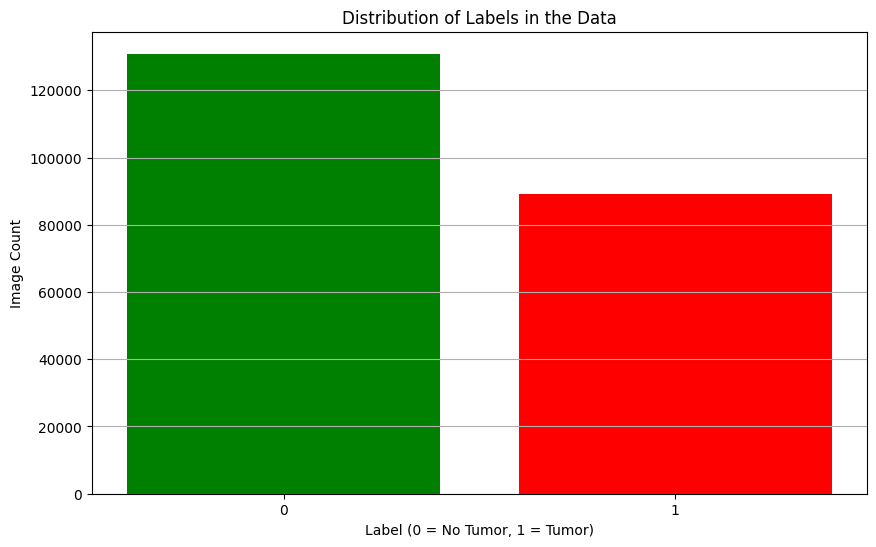

In [22]:
labels, counts = zip(*Counter(df["label"]).items())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=["green", "red"])
plt.xlabel("Label (0 = No Tumor, 1 = Tumor)")
plt.ylabel("Image Count")
plt.title("Distribution of Labels in the Data")
plt.xticks(labels)
plt.grid(axis='y')
plt.show()

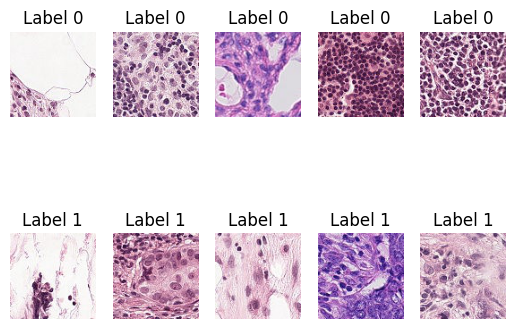

In [23]:
num_images_to_display = 5

df["path"] = df["id"].apply(lambda x: os.path.join("/kaggle/input/histopathologic-cancer-detection/train", str(x) + ".tif"))
images_with_label_0 = df[df["label"] == 0]
images_with_label_1 = df[df["label"] == 1]

for i in range(num_images_to_display):
    image = plt.imread(images_with_label_0["path"].iloc[i])

    plt.subplot(2, num_images_to_display, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label 0")

for i in range(num_images_to_display):
    image = plt.imread(images_with_label_1["path"].iloc[i])

    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label 1")


plt.show()

In [24]:
unique_dimensions = set()
random_indices = np.random.randint(0, len(df), 1000)
for index in random_indices:
    image = io.imread(df["path"].iloc[index])
    image_height, image_width, image_channels = image.shape
    unique_dimensions.add((image_height, image_width, image_channels))

print(f"Unique dimension: {unique_dimensions}")
print(f"Image Height: {image_height} pixels")
print(f"Image Width: {image_width} pixels")
print(f"Number of Channels (Depth): {image_channels}")
#print(f"image dim: {io.imread(df['path'].iloc[10]).shape}")

Unique dimension: {(96, 96, 3)}
Image Height: 96 pixels
Image Width: 96 pixels
Number of Channels (Depth): 3


In [25]:
df["label"] = df["label"].astype(str)
df_0 = df[df["label"] == "0"].sample(10000, random_state=42)
df_1 = df[df["label"] == "1"].sample(10000, random_state=42)
df_subset = pd.concat([df_0, df_1], ignore_index=True)

train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(df_subset["path"], df_subset["label"], test_size=0.2, random_state=42)

In [27]:
# Create directory called train_data and copy the training data into it
train_dir = "train_data"
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)
os.makedirs(os.path.join(train_dir, "0"))
os.makedirs(os.path.join(train_dir, "1"))
for file_path, label in zip(train_file_paths, train_labels):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(train_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(train_dir, "1", name))

# Create directory called test_data and copy the test data into it
test_dir = "test_data"
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)
os.makedirs(os.path.join(test_dir, "0"))
os.makedirs(os.path.join(test_dir, "1"))
for file_path, label in zip(test_file_paths, test_labels):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(test_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(test_dir, "1", name))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
    seed=42
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [35]:
# MODEL

#from tf.keras.models import Sequential, load_model
#from tf.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
#from tf.keras.optimizers import RMSprop, SGD
#from tf.keras.preprocessing.image import ImageDataGenerator

# Hyperparameters
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
training_epochs = 10
batch_size = 32
dropout_rate = 0.25

model = tf.keras.Sequential()
pool_size = (3, 3)
filter_size = (3, 3)

# Convolutional layers
model.add(tf.keras.layers.Conv2D(16, filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(tf.keras.layers.Conv2D(16, filter_size, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size))

model.add(tf.keras.layers.Conv2D(32, filter_size, activation='relu'))
model.add(tf.keras.layers.Conv2D(32, filter_size, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size))

model.add(tf.keras.layers.Conv2D(64, filter_size, activation='relu'))
model.add(tf.keras.layers.Conv2D(64, filter_size, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size))

# Convert to 1D vector
model.add(tf.keras.layers.Flatten())

# Classification layers
model.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))



In [36]:
# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,753 (299.82 KB)

 Trainable params: 76,529 (298.94 KB)

 Non-trainable params: 224 (896.00 B)

In [37]:
# Train the model
train_steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps_per_epoch=test_generator.n//test_generator.batch_size
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=training_epochs,
    validation_data=test_generator,
    validation_steps=validation_steps_per_epoch
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 265ms/step - accuracy: 0.6814 - loss: 0.6047 - val_accuracy: 0.7585 - val_loss: 0.5375
Epoch 2/10


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
# Access the training history from the 'history' object of each model
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

# Create a subplot for training loss for Model 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss (Model )', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss (Model )', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for Model ')
plt.grid(True)

plt.tight_layout()
plt.show()